In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

In [10]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [ ]:
file_name = "general" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")


times_to_add = 8

x_data = np.concatenate([x_data] + [x_data + np.random.normal(0,0.1,x_data.shape) for i in range(times_to_add)])
y_intent = np.concatenate([y_intent] + [y_intent for i in range(times_to_add)])

In [ ]:
def plot_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

In [ ]:
def get_intent_classifier(input_dim):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    x = Reshape((200, 16, 1))(x)
    x = Conv2D(10, (3, 1), kernel_regularizer=l2(0.01), strides=(1,1), padding="same")(x)
    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)

    x = Conv2D(100,(2,16), kernel_regularizer=l1(0.01), strides=(1,1))(x)

    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)
    x = Permute((1,3,2))(x)
    x = Reshape((50,100))(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    x = Flatten()(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="intent_classifier")
    return model

In [ ]:
model_name = "intent_classifier_all"

input_dim = x_data.shape[1:]

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=[0,1],
                                                 y = y_intent)
class_weights = {k:v for k,v in enumerate(class_weights)}
print(class_weights)

In [5]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
dir(opt)

['_HAS_AGGREGATE_GRAD',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_gradients',
 '_assert_valid_dtypes',
 '_call_if_callable',
 '_checkpoint_dependencies',
 '_clipnorm',
 '_clipnorm_fn',
 '_clipvalue',
 '_clipvalue_fn',
 '_compute_gradients',
 '_create_all_weights',
 '_create_hypers',
 '_create_or_restore_slot_variable',
 '_create_slots',
 '_create_slots_for_sharded_variables',
 '_decayed_lr',
 '_deferred_dependencies',
 '_deferred_slot_restorations',
 '_dense_apply_args',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_distributed_apply',
 '_distribution_strategy',
 '_distri

In [7]:
opt.decay

<tf.Variable 'decay:0' shape=() dtype=float32, numpy=0.0>

In [7]:



classifier = get_intent_classifier(input_dim)
classifier.compile(optimizer=keras.optimizers.Adam(
learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy", "mse"])

#earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = keras.callbacks.ModelCheckpoint(f'data/models/{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = classifier.fit(
    x_data,
    y_intent,
    epochs=25,
    batch_size=128,
    callbacks=[mcp_save, reduce_lr_loss],
    validation_split = 0.1,
    class_weight=class_weights)

plot_history(history)




2022-11-19 13:55:28.791195: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3551552000 exceeds 10% of free system memory.
2022-11-19 13:55:41.392254: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.31GiB (rounded to 3551552000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-19 13:55:41.392860: W tensorflow/core/common_runtime/bfc_allocator.cc:491] **__________________________________________________________________________________________________


KeyboardInterrupt: 

In [ ]:
classifier = keras.models.load_model(f'data/models/{model_name}.hdf5')
classifier.trainable = False
classifier.summary()

y_eval = y_intent[:len(y_gesture)//5]

y_out = classifier(x_data[:len(y_gesture)//5])
y_pred = np.array((y_out >= 0.5)).astype(int)

print(y_pred)

f1 = f1_score(y_eval, y_pred)

precision_score = sklearn.metrics.precision_score(y_eval, y_pred)
recall_score = sklearn.metrics.recall_score(y_eval, y_pred)

print(f"| f1 score: {round(f1, 3)} | precision score: {round(precision_score, 3)} | recall score: {round(recall_score, 3)} ")


In [ ]:
print(classifier(x_data[:5]) , y_intent[:5])

In [ ]:
x_data.shape

## VAE With classification loss

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, _classifier, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.classifier = _classifier
        #self.classifier = keras.models.load_model(f'data/models/{model_name}.hdf5')

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.classification_loss_tracker = keras.metrics.Mean(
            name="classification_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            data_probability = self.classifier(data)
            reconstruction_probability = self.classifier(reconstruction)
            classification_loss = tf.reduce_mean(abs(data_probability - reconstruction_probability))

            reconstruction_loss = (1.0/200) * tf.reduce_mean(tf.reduce_sum(keras.losses.mse(data, reconstruction), axis=1) * data_probability) # 

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = 50 * reconstruction_loss + kl_loss + classification_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
latent_dim = 200

input_dim = x_data.shape[1:]

inputs = keras.Input(shape=input_dim)

x = inputs
x = Reshape((200, 16, 1))(x)
x = Conv2D(10, (3, 1), kernel_regularizer=l2(0.01), strides=(1,1), padding="same")(x)
x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)

x = Conv2D(100,(2,16), kernel_regularizer=l1(0.01), strides=(1,1))(x)

x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)
x = Permute((1,3,2))(x)
x = Reshape((50,100))(x)

x = layers.SpatialDropout1D(0.2)(x)
x = Conv1D(50, 4, strides=2, padding="same")(x)
x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

x = layers.SpatialDropout1D(0.2)(x)
x = Conv1D(50, 4, strides=2, padding="same")(x)

x = LSTM(latent_dim)(x)

z_mean = layers.Dense(latent_dim, name="z_mean" )(x) # kernel_initializer=keras.initializers.Zeros()
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer=keras.initializers.Zeros())(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = latent_inputs


latent_inputs = keras.Input(shape=(latent_dim,))
x = latent_inputs
#x = layers.Reshape((latent_dim))(x)
x = layers.RepeatVector(25)(x)
#x = layers.Permute((2,1))(x)
print(x)

x = layers.LSTM(100, activation="relu", input_shape=(25,latent_dim), return_sequences=True)(x)

print(x)

x = layers.TimeDistributed(layers.Dense(100, activation="relu"))(x)
x = layers.TimeDistributed(layers.Dense(16))(x)

print(x)

x = layers.Conv1D(16,4, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,4, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,8, padding="same")(x)
x = layers.UpSampling1D(size=2)(x)
x = layers.Conv1D(16,8, padding="same")(x)

decoder_outputs = x

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

In [ ]:
sample_weights = np.array([class_weights[i] for i in y_intent[:len(y_gesture)]])
print(sample_weights)

In [ ]:
np.unique(sample_weights, return_counts=1)

In [ ]:
N = len(y_gesture)

unweighted_data = x_data[:N]
weighted_data = np.concatenate([unweighted_data] + [unweighted_data[(y_intent == 1)[:N]] for i in range(20)])

vae = VAE(encoder, decoder, classifier)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(weighted_data, epochs=50, batch_size=128, ) #, class_weight=class_weights) sample_weight=sample_weights

In [ ]:
history = vae.fit(weighted_data, epochs=50, batch_size=128, ) #, class_weight=class_weights) sample_weight=sample_weights

In [ ]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['kl_loss'], label='kl_loss')
plt.plot(np.array(history.history['reconstruction_loss'])*10, label='reconstruction')
plt.legend()
plt.show()

In [ ]:
classifier(vae.decoder.predict(vae.encoder.predict(x_data[:1])[0]))

In [45]:
from sklearn.manifold import TSNE
import pandas as pd

def dimension_reduction(z_pca, labels) -> pd.DataFrame:

  visualisation = TSNE(n_components=3).fit_transform(z_pca)
  df = pd.DataFrame(visualisation, columns = ["dimension 1", "dimension 2", "dimension 3"])
  df["labels"] = labels
  return df

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7/7 [==============================] - 0s 3ms/step
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

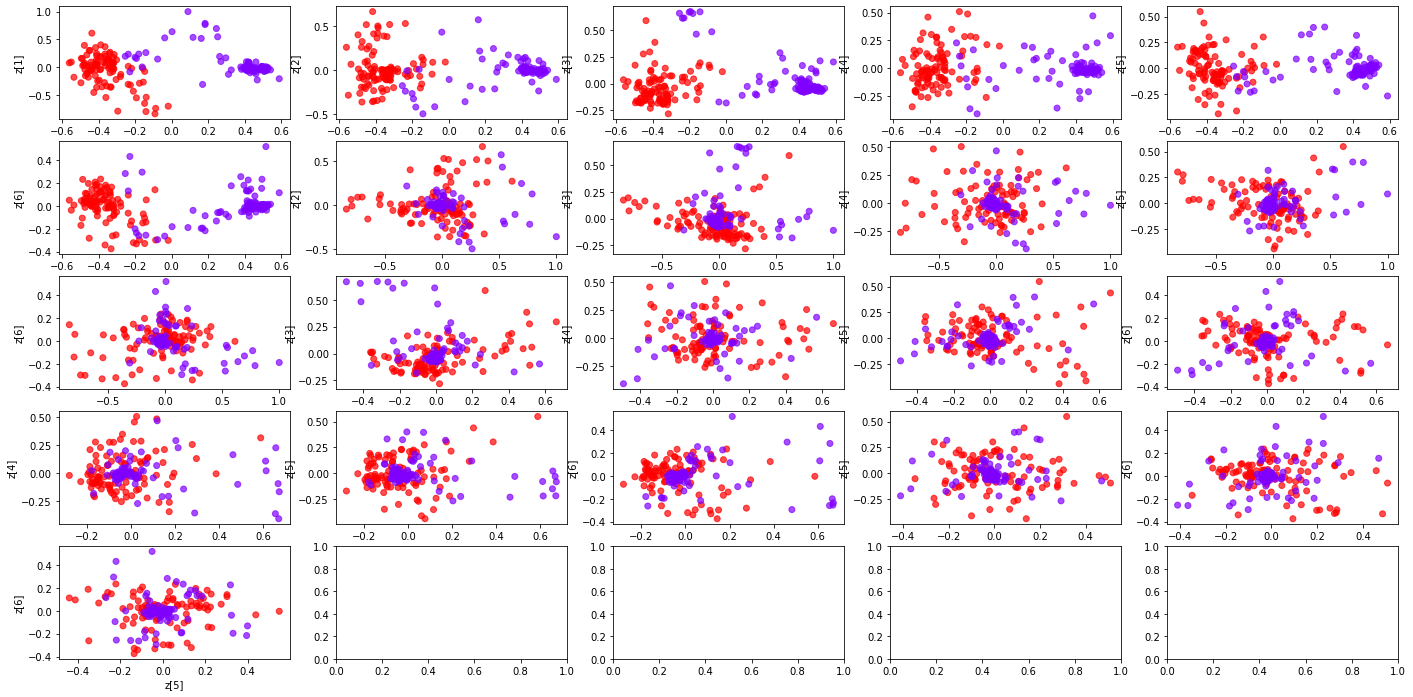

In [65]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    pca = PCA()
    z_pca = pca.fit_transform(z_mean)
    #z_pca = z_mean

    fig, ax = plt.subplots(5,5, figsize=(24,12))

    pair_set = [(i,j) for i in range(7) for j in range(i+1,7)]
    print(pair_set)
    
    print(labels)

    for ix, (i,j) in enumerate(pair_set):
        ax[divmod(ix, 5)].scatter(z_pca[:, i], z_pca[:, j], c=labels, alpha=0.7, cmap = "rainbow")
        ax[divmod(ix, 5)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 5)].set_ylabel(f"z[{j}]")
    #plt.colorbar()
    
    plt.show()

def visualise(vae, data, labels):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    pca = PCA(20)
    z_pca = pca.fit_transform(z_mean)
    
    df = dimension_reduction(z_pca, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"], df["dimension 3"], c = df["labels"], cmap = "rainbow") #  
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    #plt.colorbar()
    
    #plt.show()

    
# [:len(y_gesture)]
    
intent_x = np.array(list(x_data[:100])+list(x_data[-100:]))
intent_y = np.array(list(y_intent[:100]) + list(y_intent[-100:]))

user_x = x_data[2000:3100]
user_y = y_user.argmax(axis=1)[2000:3100]
    
#visualise(vae, intent_x, intent_y)
print(intent_y)

plot_label_clusters(vae, intent_x, intent_y,)

In [66]:
latent_space, _, _ = vae.encoder.predict(x_data[:len(y_gesture)])



1071/1071 [==============================] - 3s 3ms/step


In [55]:
np.unique(y_intent[:len(y_gesture)], return_counts=True)

(array([0, 1], dtype=int32), array([30771,  3484]))

In [56]:
len(x_data)

308295

1/1 [==============================] - 0s 24ms/step


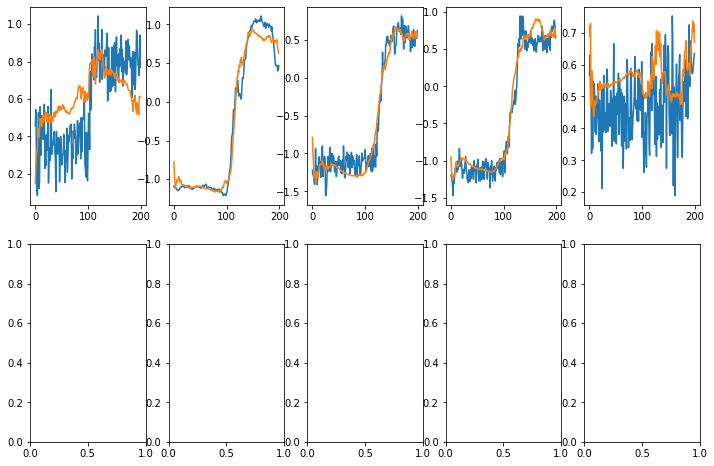

'\nfor i in random.sample(range(0, len(x_data[y_intent==0])), 5):\n    enc = vae.encoder.predict(x_data[y_intent==0][i:i+1])\n    dec = vae.decoder.predict(enc[0])\n    ax[divmod(j,5)].plot(x_data[y_intent==0][i,:,0])\n    ax[divmod(j,5)].plot(dec[0,:,0])\n    \n    j += 1\n\nplt.show()'

In [57]:
import random

fig,ax = plt.subplots(2,5, figsize=(12,8))
j = 0

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 5):
    enc = vae.encoder.predict(filtered[i:i+1])
    dec = vae.decoder.predict(enc[0])
    ax[divmod(j,5)].plot(filtered[i,:,0])
    ax[divmod(j,5)].plot(dec[0,:,0])
    
    j += 1

plt.show()


"""
for i in random.sample(range(0, len(x_data[y_intent==0])), 5):
    enc = vae.encoder.predict(x_data[y_intent==0][i:i+1])
    dec = vae.decoder.predict(enc[0])
    ax[divmod(j,5)].plot(x_data[y_intent==0][i,:,0])
    ax[divmod(j,5)].plot(dec[0,:,0])
    
    j += 1

plt.show()"""

1/1 [==============================] - 0s 27ms/step


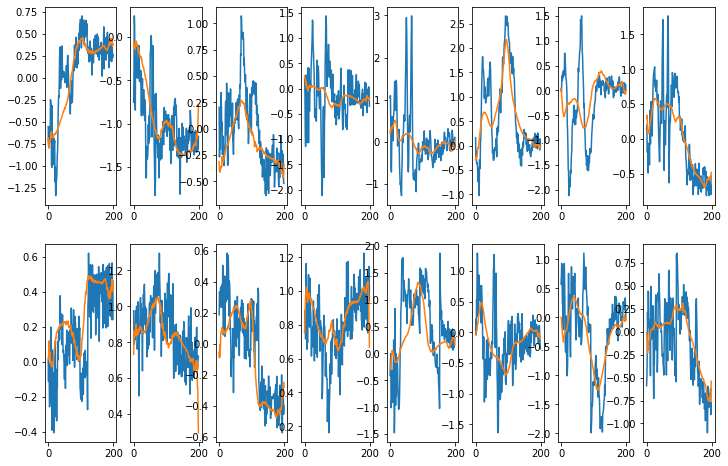

In [58]:
fig,ax = plt.subplots(2,8, figsize=(12,8))

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 1):
    for j in range(16):
        enc = vae.encoder.predict(filtered[i:i+1])
        dec = vae.decoder.predict(enc[0])
        ax[divmod(j,8)].plot(filtered[i,:,j])
        ax[divmod(j,8)].plot(dec[0,:,j])

plt.show()

In [90]:
tf.reduce_mean(abs(classifier(x_data[:1]) - y_intent[:1]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [88]:
y_intent[:1]

array([1], dtype=int32)

In [89]:
classifier(x_data[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6278042e-22]], dtype=float32)>